# Electron spline modelling

Write your desired energy and applicator in the cell immediately below then from the "Cell" menu above select "Run All"

In [1]:
energyRequest = 12
applicatorRequest = '10x10'
ssdRequest = 110

### Input and output file locations

In [2]:
tag = '%dE_%sapp_%dSSD' %(energyRequest, applicatorRequest, ssdRequest)

path2datafile = 'input/measured_output_factors.csv'
path2outputfile = 'output/' + tag + '_report.html' 

### Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

### Modules

In [3]:
import plotly as py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import SmoothBivariateSpline

from scipy.stats import shapiro, probplot, ttest_1samp

from scipy.special import gamma

from scipy.optimize import basinhopping

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

import os

from io import BytesIO
import urllib
import base64

from IPython.display import HTML, display

pylab.rcParams['savefig.dpi'] = 120

### Loading data

In [4]:
measuredRawData = pd.DataFrame.from_csv(path2datafile,index_col=False)

physicists = measuredRawData['Physicists'].values
date = measuredRawData['Date Measured'].values

energy = measuredRawData['Energy (MeV)'].values
applicator = measuredRawData['Applicator (cm x cm)'].values
insert = measuredRawData['Insert (cm x cm)'].values
shape = measuredRawData['Shape'].values

comment = measuredRawData['Comment'].values
ssd = measuredRawData['SSD (cm)'].values

detector = measuredRawData['Detector'].values
rawOutputFactor = measuredRawData['Output Factor'].values

useFactor = measuredRawData['Use Factor (Y/N)'].values

In [5]:
outputFactor = np.zeros(np.shape(energy))

for i, outputFactorString in enumerate(rawOutputFactor):
    
    try:        
        outputFactor[i] = np.float(outputFactorString)
        
    except:        
        outputFactor[i] = np.nan

In [6]:
width = np.zeros(np.shape(energy))
length = np.zeros(np.shape(energy))

for i, insertString in enumerate(insert):
    
    dimenstionsString = insertString.split("x")
    
    sideA = np.float(dimenstionsString[0])
    sideB = np.float(dimenstionsString[1])
    
    if sideA < sideB:
        width[i] = sideA
        length[i] = sideB
        
    else:
        
        width[i] = sideB
        length[i] = sideA
        
        
ratio = width/length

eqPonA = 2*( 3*(ratio+1) - np.sqrt( (3*ratio+1)*(ratio+3) ) ) / width

In [7]:
ref = (
    (energy == energyRequest) & 
    (applicator == applicatorRequest) & 
    (ssd == ssdRequest) &
    ((shape == 'Circle') | (shape == 'Oval')) &
    (useFactor != 'N') &
    ~np.isnan(outputFactor)
)


### Sign into plotly and load/create site specific key

In [8]:
py.sign_in('SimonBiggs', 'oas177ahva')

if (os.path.isfile('key.txt')):
    
    f = open('key.txt','r')
    key = f.read()
    f.close()

else:

    key = "%04d-%04d-%04d-%04d-%04d" %tuple((np.floor(np.random.rand(5)*1e4)).astype(int))
    
    f = open('key.txt','w')
    f.write(key)
    f.close()

### Create the marker labels

In [9]:
marker_labels = [0,]*sum(ref)

for i in range(sum(ref)):
    
    marker_labels[i] = (
        'Applicator: %s cm'
        +'<br>Energy: %d MeV'
        +'<br>SSD: %d cm'
        +'<br>Width: %0.1f cm'
        +'<br>Length: %0.1f cm'
        +'<br>Output factor: %0.3f'
        +'<br>Physicists: %s'
        +'<br>Date: %s'
        +'<br>Shape: %s'
        +'<br>Detector: %s'
        +'<br>Use Factor: %s'
        
    ) %(
        applicator[ref][i],
        energy[ref][i],
        ssd[ref][i],
        width[ref][i],
        length[ref][i],
        outputFactor[ref][i],
        physicists[ref][i],
        date[ref][i],
        shape[ref][i],
        detector[ref][i],
        useFactor[ref][i]
    )



### Create the width alone plot

In [10]:
plotScatter = Scatter(x=width[ref], y=outputFactor[ref], 
                      text=marker_labels,
                      mode='markers', 
                      marker=Marker(size=15), 
                      name='Measured data')

dataList = [plotScatter]


xSpline = np.linspace(width[ref].min(),width[ref].max(),100)
xSpline = np.unique(np.append(xSpline,width[ref]))

try:
    spline1 = UnivariateSpline(width[ref],outputFactor[ref],k=1)
    ySpline1 = spline1(xSpline)
    plotSpline1 = Scatter(x=xSpline, y=ySpline1,
                         line=Line(width=2,opacity=0.5), 
                         name='First order')
except:
    print("Cannot create first order fit")
else:
    dataList = dataList + [plotSpline1]


try:
    spline2 = UnivariateSpline(width[ref],outputFactor[ref],k=2)
    ySpline2 = spline2(xSpline)
    plotSpline2 = Scatter(x=xSpline, y=ySpline2,
                         line=Line(width=2,opacity=0.5), 
                         name='Second order')
except:
    print("Cannot create second order fit")
else:
    dataList = dataList + [plotSpline2]



data = Data(dataList)

layout = Layout(title=('Data plotted against width for lookup purposes'),
                xaxis=XAxis(title='Width (cm)'),
                yaxis=YAxis(title='Output factor'),
                hovermode='closest')

fig_width_input = Figure(data=data, layout=layout)

fig_width = py.iplot(fig_width_input, 
         filename='%s_electron-fits_widthalone_' + tag)

HTML(fig_width.embed_code)

## Create width and length fit

### Define threshold functions

#### Angle gap

In [11]:
def single_angle_gap(xTest,yTest,xData,yData,xScale,yScale):
    
    xi = xScale * (xData - xData.min()) / xData.ptp()
    yi = yScale * (yData - yData.min()) / yData.ptp()
    
    xVal = xScale * (xTest - xData.min()) / xData.ptp()
    yVal = yScale * (yTest - yData.min()) / yData.ptp()
    
    dx = xi - xVal
    dy = yi - yVal
    
    if any((dx == 0) & (dy == 0)):
        gap = 0
        return gap
        
    theta = np.arctan(dy/dx)
    theta[dx<0] = theta[dx<0] + np.pi
    theta[(dx>0) & (dy<0)] = theta[(dx>0) & (dy<0)] + 2*np.pi
    theta[(dx==0) & (dy>0)] = np.pi/2
    theta[(dx==0) & (dy<0)] = 3*np.pi/2

    test = np.sort(theta)
    test = np.append(test,test[0] + 2*np.pi)
    gap = np.max(np.diff(test))*180/np.pi

    return gap


def angle_gap(xTest,yTest,xData,yData,xScale,yScale):
    
    dim = np.core.fromnumeric.shape(xTest)  
    
    if np.size(dim) == 0:
        gap = single_angle_gap(xTest,yTest,xData,yData,xScale,yScale)
        
        return gap
    
    
    gap = np.zeros(dim)
    
    
    if np.size(dim) == 1:
        for i in range(dim[0]):
            gap[i] = single_angle_gap(xTest[i],yTest[i],xData,yData,xScale,yScale)
            
        return gap
    
    
    for i in range(dim[0]):
        for j in range (dim[1]):
            gap[i,j] = single_angle_gap(xTest[i,j],yTest[i,j],xData,yData,xScale,yScale)

    return gap

#### Fit give

In [12]:
def single_fit_give(xTest,yTest,xData,yData,zData,s=None,kx=2,ky=2):
        
    initialFitReturn = SmoothBivariateSpline(xData,yData,zData,kx=kx,ky=ky,s=s).ev(xTest,yTest)
    
    adjXData = np.append(xData,xTest)
    adjYData = np.append(yData,yTest)
    
    posAdjZData = np.append(zData,initialFitReturn + 1)
    negAdjZData = np.append(zData,initialFitReturn - 1)
    
    posFitReturn = SmoothBivariateSpline(adjXData,adjYData,posAdjZData,kx=kx,ky=ky,s=s).ev(xTest,yTest)
    negFitReturn = SmoothBivariateSpline(adjXData,adjYData,negAdjZData,kx=kx,ky=ky,s=s).ev(xTest,yTest)
    
    posGive = posFitReturn - initialFitReturn
    negGive = initialFitReturn - negFitReturn
    
    give = np.mean([posGive, negGive])
    
    return give


def fit_give(xTest,yTest,xData,yData,zData,s=None,kx=2,ky=2):
    
    dim = np.core.fromnumeric.shape(xTest)
    
    if np.size(dim) == 0:
        give = single_fit_give(xTest,yTest,xData,yData,zData,s=s,kx=kx,ky=ky)
        
        return give
    
    
    give = np.zeros(dim)
    
    
    if np.size(dim) == 1:
        for i in range(dim[0]):
            give[i] = single_fit_give(xTest[i],yTest[i],xData,yData,zData,s=s,kx=kx,ky=ky)
            
        return give
    
    
    for i in range(dim[0]):
        for j in range (dim[1]):
            give[i,j] = single_fit_give(xTest[i,j],yTest[i,j],xData,yData,zData,s=s,kx=kx,ky=ky)

    return give

### Create the fit

In [13]:
numUniquePoints = len(np.unique(insert[ref]))


if numUniquePoints < 6:
    splinefail = True
    splineOrder = 0
else:
    splinefail = False



if not(splinefail):
    if numUniquePoints < 11:
        kx = 1
        ky = 1
        splineOrder = 1

    else:
        kx = 2
        ky = 2
        splineOrder = 2
    
    bivariateSpline = SmoothBivariateSpline(width[ref],eqPonA[ref],outputFactor[ref],kx=kx,ky=ky)

### Calculate the mesh and find the threshold boundaries

In [14]:
minVal = np.floor(np.min(width[ref])*10)/10
maxVal = np.ceil(np.max(length[ref])*10)/10 + 0.1

x = np.arange(minVal,maxVal,0.1)
y = x.copy()

xx, yy = np.meshgrid(x,y)

if not(splinefail):
    
    mesh_width = xx.copy()
    mesh_width[xx>yy] = yy[xx>yy]
    
    mesh_length = xx.copy()
    mesh_length[yy>xx] = yy[yy>xx]
    
    mesh_ratio = mesh_width / mesh_length
    
    mesh_eqPonA = 2*( 3*(mesh_ratio+1) - np.sqrt( (3*mesh_ratio+1)*(mesh_ratio+3) ) ) / mesh_width
       
    zz = bivariateSpline.ev(mesh_width, mesh_eqPonA)
    give = fit_give(mesh_width,mesh_eqPonA,width[ref],eqPonA[ref],outputFactor[ref],kx=kx,ky=ky)
    gap = angle_gap(mesh_width,mesh_eqPonA,width[ref],eqPonA[ref],1,1)

    outOfTolerance = (give > 0.5) | (gap > 180)

    zz[outOfTolerance] = np.nan
    
else:
    
    zz = np.empty(np.shape(xx))
    zz[:] = np.nan
    
zz = np.floor(zz*1e4)/1e4

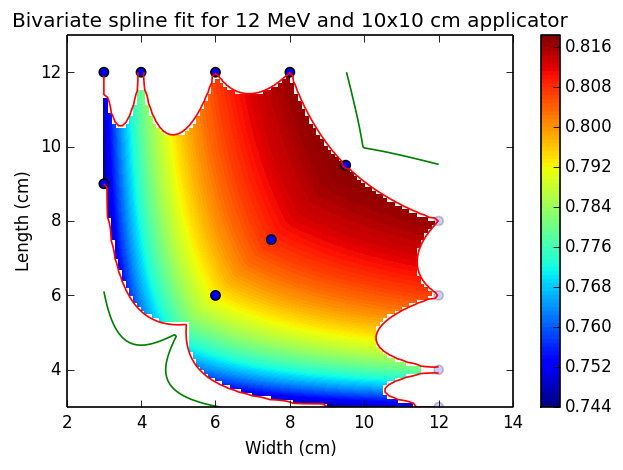

In [15]:
if not(splinefail):

    c = plt.contourf(xx,yy,zz,100)
    plt.colorbar(c)

    plt.contour(xx,yy,give,levels=[0.5],colors='g')
    plt.contour(xx,yy,gap,levels=[180],colors='r')

    plt.scatter(width[ref],length[ref],s=30)
    plt.scatter(length[ref],width[ref],s=30,alpha=0.2)

    plt.xlabel('Width (cm)')
    plt.ylabel('Length (cm)')
    plt.title('Bivariate spline fit for %d MeV and %s cm applicator' %(energyRequest, applicatorRequest))

    plt.axis('equal')

In [16]:
dtick = 0.02

colourWashMin = int(np.floor(np.min(outputFactor[ref])*100))/100
colourWashMax = int(np.ceil(np.max(outputFactor[ref])*100))/100

nticks = int(np.floor((colourWashMax - colourWashMin)*100 + 1))

tick0 = colourWashMin

if not(splinefail):
    measured1 = Scatter(x = width[ref],
                        y = length[ref],
                        text=marker_labels,
                        mode='markers', 
                        marker=Marker(size=10),
                        name='Measured data',
                        xaxis='x1')

    measured2 = Scatter(x = length[ref],
                        y = width[ref],
                        text=marker_labels,
                        mode='markers', 
                        marker=Marker(size=10,opacity=0.3),
                        name='Measured data',
                        xaxis='x1')


    colorbar = ColorBar(title='Output factor',
                        titleside='right',
                        autotick=False,
                        nticks=nticks,
                        dtick=dtick,
                        tick0=tick0)


    contour1 = Contour(z=zz,
                       x=x,
                       y=y,
                       opacity=0.8,
                       colorscale='YIGnBu',
                       reversescale=True,
                       ncontours='100',
                       zauto=False,
                       zmin=colourWashMin,
                       zmax=colourWashMax,
                       autocontour=True,
                       contours=Contours(coloring='heatmap'),
                       line=Line(width=0),
                       name='Spline fit',
                       xaxis='x1',
                       colorbar=colorbar)


    contour2 = Contour(z=zz,
                       x=x,
                       y=y,
                       opacity=0.8,
                       colorscale='YIGnBu',
                       reversescale=True,
                       ncontours='100',
                       zauto=False,
                       zmin=colourWashMin,
                       zmax=colourWashMax,
                       autocontour=True,
                       contours=Contours(coloring='heatmap'),
                       line=Line(width=0),
                       name='Spline fit',
                       xaxis='x2',
                       colorbar=colorbar)

    
    
    data = Data([measured1,measured2,contour1,contour2])

    if splineOrder == 2:
        
        title = ('Bivariate quadratic spline fit using the parameters '
                 '<i>equivalent width</i> and <i>equivalent perimeter on area</i>')
        
    elif splineOrder == 1:
        
        title = 'Plane fit using the parameters <i>equivalent width</i> and <i>equivalent perimeter on area</i>'
    
    
    layout = Layout(xaxis1=XAxis(domain=[0,0.45],title='Width (cm)'),
                    xaxis2=XAxis(domain=[0.55,1],title='Width (cm)'),
                    yaxis=YAxis(title='Length (cm)'),
                    title=title,
                    hovermode='closest',               
                    showlegend=False)


    fig_widthlength_input = Figure(data=data, layout=layout)

    fig_widthlength = py.iplot(fig_widthlength_input, 
             filename='%s_electron-fits_widthlength_' + tag)
    
    display(HTML(fig_widthlength.embed_code))

### Create the residuals histogram

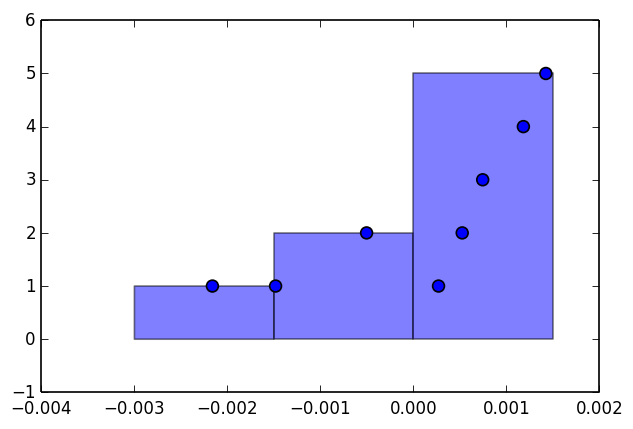

In [17]:
if not(splinefail):
    
    residuals_lengthwidth = outputFactor[ref] - bivariateSpline.ev(width[ref], eqPonA[ref])
    
    binSize = np.floor(4 * residuals_lengthwidth.ptp() / len(residuals_lengthwidth) / 0.0005) * 0.0005
    binStart = np.floor(residuals_lengthwidth.min()/binSize)*binSize
    binEnd = np.ceil(residuals_lengthwidth.max()/binSize)*binSize

    bins = np.arange(binStart,binEnd+binSize,binSize)

    
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - residuals_lengthwidth),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):

        binRef = (binNum == i)

        representative_height[binRef] = np.arange(sum(binRef)) + 1

        
    plt.hist(residuals_lengthwidth,bins,alpha=0.5)
    plt.scatter(residuals_lengthwidth,representative_height,zorder=2,s=50,)

In [18]:
if not(splinefail):
    residualsScatter = Scatter(x=residuals_lengthwidth, 
                               y=representative_height, 
                               text=marker_labels,
                               mode='markers', 
                               marker=Marker(size=15), 
                               name='Measured data')


    residualsHistogram = Histogram(x=residuals_lengthwidth,
                                   autobinx=False,
                                   xbins=XBins(start=binStart,end=binEnd,size=binSize),
                                   marker=Marker(color='rgb(165,231,255,0.5)',
                                                 line=Line(color='black',width=2)),
                                   name='Residuals histogram')


    data = Data([residualsScatter,residualsHistogram])

    layout = Layout(title='Histogram of residuals for identifying outliers',
                    xaxis=XAxis(title=('Output factor residual error '
                                       '(measured factor - fitted factor)'), zeroline=False),
                    yaxis=YAxis(title='Frequency', zeroline=False),
                    hovermode='closest',
                    showlegend=False)

    fig_residualsHist_input = Figure(data=data, layout=layout)

    fig_residualsHist = py.iplot(fig_residualsHist_input, 
                    filename='%s_electron-fits_widthlength_residual_' + tag)
    
    display(HTML(fig_residualsHist.embed_code))

## Prediction percent difference

In [19]:
def c4(n):
    
    output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
    if np.isnan(output):
        output = 1
        
    return output

0.00241130528537
-0.000218761381069


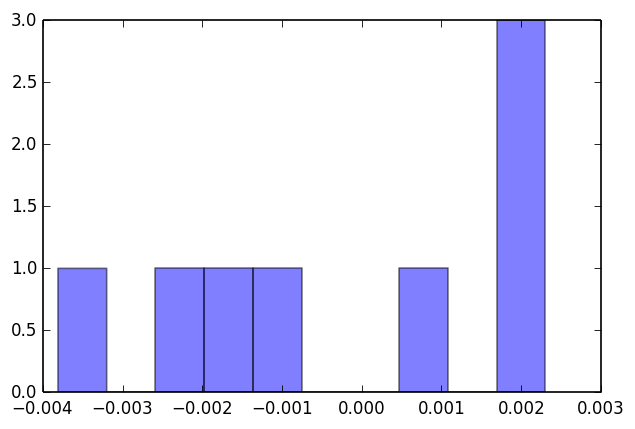

In [20]:
if not(splinefail):
    predictionValue = np.zeros(sum(ref))

    for i in range(sum(ref)):

        widthTest = np.delete(width[ref],i)
        eqPonATest = np.delete(eqPonA[ref],i)
        outputFactorTest = np.delete(outputFactor[ref],i)

        predictionTestSpline = SmoothBivariateSpline(widthTest,eqPonATest,outputFactorTest,kx=kx,ky=ky)

        predictionValue[i] = predictionTestSpline.ev(width[ref][i],eqPonA[ref][i])
        

    predictionDifference = outputFactor[ref] - predictionValue

    plt.hist(predictionDifference,alpha=0.5)

    predictionStd = np.std(predictionDifference,ddof=1) / c4(len(predictionDifference))

    print(predictionStd)
    print(np.mean(predictionDifference))

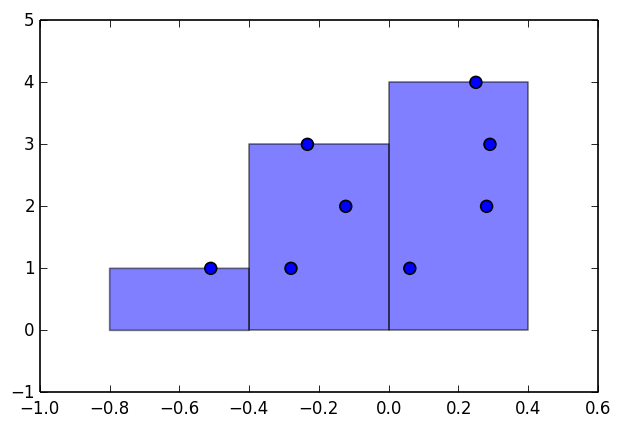

In [21]:
if not(splinefail):
    
    percentDifference = 100*(outputFactor[ref] - predictionValue)/outputFactor[ref]
       
    binSize = np.floor(4 * percentDifference.ptp() / len(percentDifference) / 0.05) * 0.05
    binStart = np.floor(percentDifference.min()/binSize)*binSize
    binEnd = np.ceil(percentDifference.max()/binSize)*binSize

    bins = np.arange(binStart,binEnd+binSize,binSize)

    
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - percentDifference),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):

        binRef = (binNum == i)

        representative_height[binRef] = np.arange(sum(binRef)) + 1

        
    plt.hist(percentDifference,bins,alpha=0.5)
    plt.scatter(percentDifference,representative_height,zorder=2,s=50,)

In [22]:
if not(splinefail):
    residualsScatter = Scatter(x=percentDifference, 
                               y=representative_height, 
                               text=marker_labels,
                               mode='markers', 
                               marker=Marker(size=15), 
                               name='Measured data')


    residualsHistogram = Histogram(x=percentDifference,
                                   autobinx=False,
                                   xbins=XBins(start=binStart,end=binEnd,size=binSize),
                                   marker=Marker(color='rgb(165,231,255,0.5)',
                                                 line=Line(color='black',width=2)),
                                   name='Percent difference')

    # residualsHistogram = Histogram(x=residuals_lengthwidth)


    data = Data([residualsScatter,residualsHistogram])

    layout = Layout(title='Distribution of percent difference between measured and predicted factors',
                    xaxis=XAxis(title=('Percent difference &emsp; '
                                       '[  100 &times; ( measured - predicted ) / measured  ]'), zeroline=False),
                    yaxis=YAxis(title='Frequency', zeroline=False),
                    hovermode='closest',
                    showlegend=False)

    fig_predictionDiffHist_input = Figure(data=data, layout=layout)

    fig_predictionDiffHist = py.iplot(fig_predictionDiffHist_input, 
                    filename='%s_electron-fits_widthlength_predictionDiff_' + tag)
    
    display(HTML(fig_predictionDiffHist.embed_code))

### Calculating Stats

In [23]:
if not(splinefail):
    t, ttestProb = ttest_1samp(percentDifference,0)
    res_ttest = "%0.4f" %(ttestProb)
    
    if ttestProb < 0.1:
        tSignificance = 'significant'
    else:
        tSignificance = 'not significant'
        
    print('t-Test: ' + res_ttest + ' which is ' + tSignificance)
    
    W, shapiroProb = shapiro(percentDifference)
    res_norm = "%0.4f" %(shapiroProb)
    
    if shapiroProb < 0.1:
        shSignificance = 'significant'
    else:
        shSignificance = 'not significant'
    
    print('Shapiro: ' + res_norm + ' which is ' + shSignificance)
    
      
    
    residualStd = np.std(percentDifference,ddof=1) / c4(len(percentDifference))
    
    res_std = "%0.2f" %(residualStd)
    print('Standard deviation with bias correction: ' + res_std)
    
    res_mean = "%0.2f" %(np.mean(percentDifference))
    print('Mean:' + res_mean)

t-Test: 0.7642 which is not significant
Shapiro: 0.3599 which is not significant
Standard deviation with bias correction: 0.31
Mean:-0.03


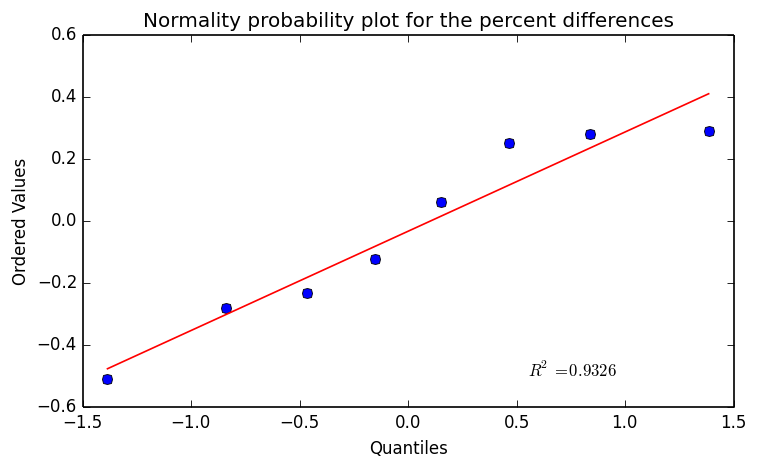

In [24]:
if not(splinefail):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111)

    probplot(percentDifference, plot=ax);

    ax.set_title("Normality probability plot for the percent differences")

    figData = BytesIO()
    pylab.savefig(figData)
    
    figData.seek(0)
    figString = urllib.parse.quote(base64.b64encode(figData.getvalue()))
    probplotImageEmbed = '<img alt="Embedded Image" src="data:image/png;base64,'+figString+'" />'

## Estimated uncertainties

### Estimated variable uncertainties via smooth bootstrapping

In [25]:
if not(splinefail):
    predictions = bivariateSpline.ev(width[ref], eqPonA[ref])

    numTrials = 5000

    resampleSpline = [0,]*numTrials
    resampledPredictions = np.zeros(np.shape(mesh_width) + (numTrials,))

    for i in range(numTrials):

        resample = np.random.normal(loc=predictions, scale=predictionStd)
        resampleSpline[i] = SmoothBivariateSpline(width[ref],eqPonA[ref],resample,kx=kx,ky=ky)

        resampledPredictions[:,:,i] = resampleSpline[i].ev(mesh_width, mesh_eqPonA)
    

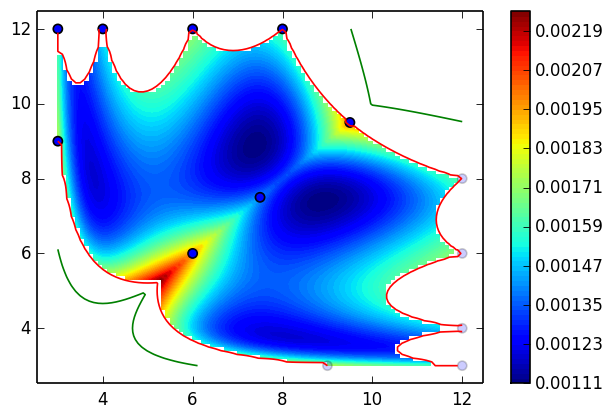

In [26]:
if not(splinefail):
    variableUncertaintyEstimate = np.std(resampledPredictions,ddof=1,axis=2) / c4(numTrials)

    variableUncertaintyEstimate[outOfTolerance] = np.nan

    c = plt.contourf(xx,yy,variableUncertaintyEstimate,100)
    plt.colorbar(c)

    plt.contour(xx,yy,give,levels=[0.5],colors='g')
    plt.contour(xx,yy,gap,levels=[180],colors='r')

    plt.scatter(width[ref],length[ref],s=30)
    plt.scatter(length[ref],width[ref],s=30,alpha=0.2)

### Estimate constant uncertainty

In [27]:
class constant_uncertainty(object):
    """Find the constant uncertainty throughout the fit.
    """
    def __init__(self, n=5, debug=False, **kwargs):
        
        self.debug=debug
        
        self.residuals = kwargs['residuals']
        self.variableUncertainty = kwargs['variableUncertainty']

                
        self.basinRequiredSuccess = n
        self.constantUncertainty = np.abs(self.uncertainty_basinhopping())
        
        self.totalUncertainty = np.sqrt(self.variableUncertainty**2 + 
                                        self.constantUncertainty**2)
        

    def c4(n):
    
        output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
        if np.isnan(output):
            output = 1

        return output
    
    
    def minimise_function(self, constantUncertaintyGuess):

        totalUncertaintyGuess = np.sqrt(self.variableUncertainty**2 + constantUncertaintyGuess**2)

        scaled = self.residuals / totalUncertaintyGuess

        scaledStd = np.std(scaled,ddof=1) / c4(len(scaled))
        
        return (scaledStd - 1)**2
        
    
    def uncertainty_basinhopping(self):

        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS'}
        
        initial_input = np.array([0.01])
        
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)
        
        return basinhoppingOutput.x
        
        
    def step_function(self,optimiserInput):

        optimiserInput[0] += np.random.normal(scale=0.01)   # x-position
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
       
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + 0.0001:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - 0.0001:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - 0.0001:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True
        

In [28]:
if not(splinefail):
    resampledPredictionsAtPoints = np.zeros(np.shape(width[ref]) + (numTrials,))

    for i in range(numTrials):

        resampledPredictionsAtPoints[:,i] = resampleSpline[i].ev(width[ref],eqPonA[ref])

    fittingUncertainty = np.std(resampledPredictionsAtPoints,ddof=1,axis=1) / c4(numTrials)
    # fittingUncertainty

    measuredUncertaintyEstimate = constant_uncertainty(residuals=predictionDifference, 
                                                       variableUncertainty=fittingUncertainty)

    measuredUncertaintyEstimate.constantUncertainty

    measuredUncertaintyString = '%0.2f%%' %(measuredUncertaintyEstimate.constantUncertainty*100)
    print(measuredUncertaintyString)

0.17%


### Estimated total uncertainty

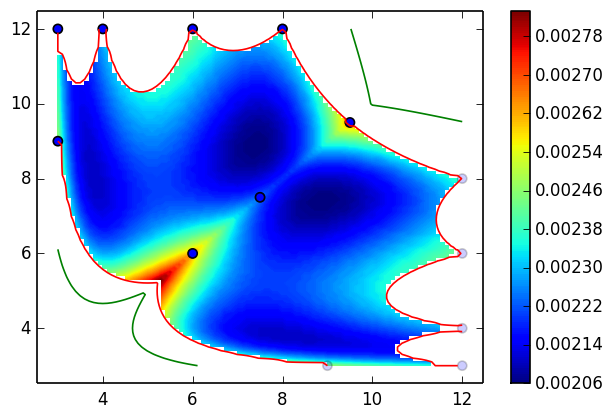

In [29]:
if not(splinefail):

    totalUncertaintyEstimate = np.sqrt(variableUncertaintyEstimate**2 + 
                                       measuredUncertaintyEstimate.constantUncertainty**2)
    
    totalUncertaintyEstimate = np.around(totalUncertaintyEstimate,decimals=5)
    
    c = plt.contourf(xx,yy,totalUncertaintyEstimate,200)
    plt.colorbar(c)

    plt.contour(xx,yy,give,levels=[0.5],colors='g')
    plt.contour(xx,yy,gap,levels=[180],colors='r')

    plt.scatter(width[ref],length[ref],s=30)
    plt.scatter(length[ref],width[ref],s=30,alpha=0.2)

In [30]:
if not(splinefail):
    measured1 = Scatter(x = width[ref],
                        y = length[ref],
                        text=marker_labels,
                        mode='markers', 
                        marker=Marker(size=10),
                        name='Measured data',
                        xaxis='x1')

    measured2 = Scatter(x = length[ref],
                        y = width[ref],
                        text=marker_labels,
                        mode='markers', 
                        marker=Marker(size=10,opacity=0.3),
                        name='Measured data',
                        xaxis='x1')


    colorbar = ColorBar(title='Estimated uncertainty',
                        titleside='right')


    contour1 = Contour(z=totalUncertaintyEstimate,
                       x=x,
                       y=y,
                       opacity=0.8,
                       colorscale='YIOrRd',
                       reversescale=True,
                       ncontours='100',
                       autocontour=True,
                       contours=Contours(coloring='heatmap'),
                       line=Line(width=0),
                       name='Estimated uncertainty',
                       xaxis='x1',
                       colorbar=colorbar)


    contour2 = Contour(z=totalUncertaintyEstimate,
                       x=x,
                       y=y,
                       opacity=0.8,
                       colorscale='YIOrRd',
                       reversescale=True,
                       ncontours='100',
                       autocontour=True,
                       contours=Contours(coloring='heatmap'),
                       line=Line(width=0),
                       name='Estimated uncertainty',
                       xaxis='x2',
                       colorbar=colorbar)

    
    
    data = Data([measured1,measured2,contour1,contour2])

    layout = Layout(xaxis1=XAxis(domain=[0,0.45],title='Width (cm)'),
                    xaxis2=XAxis(domain=[0.55,1],title='Width (cm)'),
                    yaxis=YAxis(title='Length (cm)'),
                    title='Estimated uncertainty for the prediction of a measured Output factor',
                    hovermode='closest',               
                    showlegend=False)


    fig_uncertainty_input = Figure(data=data, layout=layout)

    fig_uncertainty = py.iplot(fig_uncertainty_input, 
             filename='%s_electron-fits_uncertainty_' + tag)
    
    display(HTML(fig_uncertainty.embed_code))

## Save a summary

In [31]:
# Spline explaination
splineExplain = ('You currently have <b>%d unique widths '
                 'and lengths</b> in this set, therefore a ') %(numUniquePoints) 

if splineOrder == 1:
    splineExplain += '''<b>first order spline (aka a plane)</b> has been used to fit your data. 
                        A better fit would be achievable if you use at least eleven data points.'''
elif splineOrder == 2:
    splineExplain += ('<b>second order bivariate spline (aka quadratic bivariate spline)'
                      '</b> has been used to fit your data.')
    
else:
    splineExplain += '''a spline fit was unavailable for your data set. Please collect 
        at least six data points to use a plane to fit your data, or eleven data points 
        so that a quadratic spline can be used.'''
    

if not(splinefail):
    
    uncertaintyExplain = ('This fit has an estimated uncertainty in prediction of <b>&plusmn;' 
                          + res_std + ' %</b>.')

In [32]:
html_string = '''
<!DOCTYPE html>
<html>
    <head>
        <meta http-equiv="X-UA-Compatible" content="IE=edge" />
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>
        
            body { 
                
                background:whitesmoke;
                width: 80%;
                margin: 60px auto;
            }
            
            section.left {
                width:65%;
                float:left;
            }
            
            section {
                padding:20px;
            
            }
            
            aside {
                padding:20px;
            
            }
            
            td {
                padding:20px;            
            }
            
        </style>
    </head>
    <body>
        
        <section>
        <h1>Electron equivalent ellipse spline modelling</h1>
        </section>
        
        <section>
        <h2>Energy: ''' + str(energyRequest) + ''' MeV &emsp;&emsp;
        Applicator: ''' + str(applicatorRequest) + ''' cm &emsp;&emsp;
        SSD: ''' + str(ssdRequest) + ''' cm &emsp;&emsp;
        <i>Include reference conditions here</i></h2>
        </section>
        

        '''
    

if not(splinefail):

    html_string += '''
            
            <section class="left">
            <h3>Bivariate spline fit for interpolation purposes</h3>
            
            <p>''' + splineExplain + ' ' + uncertaintyExplain+'''</p>
            
            <p>Below is the fit formed using the parameters <i>equivalent width</i> and 
            <i>equivalent perimeter on area</i>.
            For ease of use the results are plotted with respect to <i>length</i> and <i>width</i>. 
            The valid fitting region is given as a colourwash. 
            The colour of the colourwash is representative of the fitted output factor.</p>
            
            <p>Hovering your mouse over the righthand plot will give the output factor results in the 
            <i>z</i> parameter.
            Where the <i>z</i> paramater returns null, and there is no colour wash, 
            is not a valid fitting region. This may be due either to not having enough points 
            in the direct vicinity, or the region being outside the external data 
            boundary.</p>
            
            <p>Hovering your mouse over the lefthand plot will provide you with a way 
            to lookup individual measured data points.
            Your measured data is given in blue. 
            The equivalent shape with <i>width</i> and <i>length</i> inverted is given in orange.</p>
            
            </section>
            
            <aside><i>Diagram of length and width using an ellipse goes here... 
            maybe have a semi irregular cutout and an equivalent ellipse overlay to 
            represent length and width</i></aside>
            
            <section>''' + fig_widthlength.embed_code + '''</section>
            
            <section class="left">
                <h3>Estimated total standard uncertainty in predicting a measured output factor</h3>
                <p>The following is an estimate of total standard uncertainty 
                for the prediction of a measured output factor.
                It takes into account variations in uncertainty about the fit via Smooth Bootstrapping.
                This is based upon an approximate measurement uncertainty of 
                ''' + measuredUncertaintyString + '''.</p>
            </section>
            
            <section>''' + fig_uncertainty.embed_code + '''</section>
            
            
            <section class="left">
                <h3>Distribution of the percent difference between measured and predicted factors</h3>
                <p>In order to determine the uncertainty for prediction each 
                data point in turn is removed from the fit
                and then the model attenmpts to predict the just removed point. 
                This prediction is then compared with
                the measured factor.</p>
                
                <p>Below is the distribution of percent differences between the 
                measured factors and these factor predictions
                calculated after removal. This is calculated as 
                %diff = 100 &times; ( measured - predicted ) / measured.</p>
                
                <p>It is expected that points on the edge of the fitting region would become outliers
                in this distribution due to forcing extrapolation upon the model.</p>
            
            </section>
            
            <section>''' + fig_predictionDiffHist.embed_code + '''</section>
            
            <section class="left">
                <h3>Prediction percent difference statistics</h3>
                
                <p>The percent difference <b>mean is ''' + res_mean + ''' %</b>, which is 
                ''' + tSignificance + ''' with a <b>p-value of '''+ res_ttest +'''</b>.</p>
                <p>The <b>standard deviation</b> corrected for bias using an assumtion of a normality is 
                <b>&plusmn;''' + res_std + ''' %</b>.</p>
                <p>The <b>p-value</b> for the Shapiro test for <b>normality is ''' + res_norm + '''</b>.</p>
                
                <p>A normality probability plot is given below to further investigate the 
                normality of the percent difference distribtion.</p>
                
            </section>
            
            <section>'''+probplotImageEmbed+'''</section>
            
            
            
            <section class="left">
                <h3>Identifying outliers via the residuals histogram</h3>
                <p>A histogram of the residual error between the modelled factors 
                (without removal) and the measured factors
                is given below. Its primary use is for the identification of outliers 
                in your measurement data.</p>
             </section>
             
             <section>'''+ fig_residualsHist.embed_code + '''</section>
            
            

    '''
    
else:
    
    html_string += '''
        <section>
            <h3>Bivariate spline fit for interpolation purposes unavailable</h3>
            <p>''' + splineExplain + '''</p>
        <section>
                '''
    
html_string += '''
        
        <section class="left">
        <h3>Width alone fits for lookup purposes</h3>
            <p>The univariate fits provided in the figure just below are intented to be used 
            as a guide for lookup purposes.</p>
        </section>
        
        <section>''' + fig_width.embed_code + '''</section>
    
    </body>
</html>'''

f = open(path2outputfile,'w')
f.write(html_string)
f.close()